# 10 Step Phase Shifting Technique

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from functions import load_raw_img, rad_to_deg, mask_to_dummy
from unwrapping_algorithm import phase_unwrap

### Load the 10 images

In [5]:
base_path = "img/ring/phase-shifting/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [6]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


In [7]:
mask = cv.imread('img/ring/mask/ring_mask_phase_shifting.jpg', cv.IMREAD_GRAYSCALE)

### Calculate the isoclinic parameter
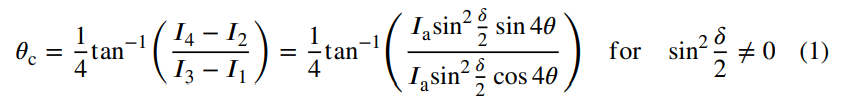

In [8]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [9]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

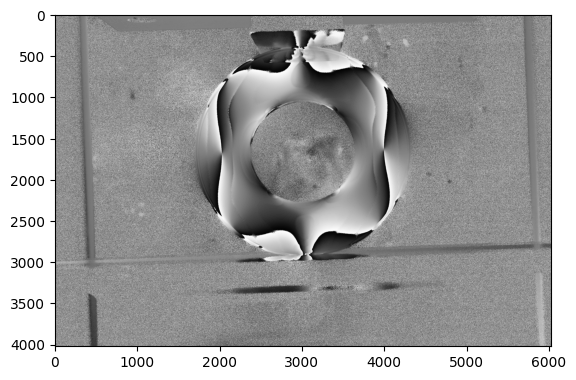

In [10]:
plt.imshow(isoclinic_param, cmap='gray')
plt.imsave('img/ring/results/ring_isocl_wr.jpg', isoclinic_param, cmap='gray')   

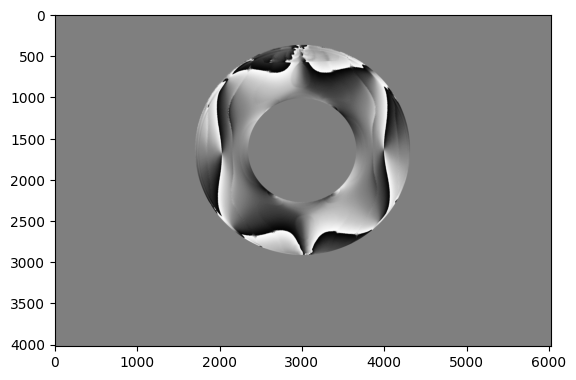

In [11]:
isoclinic_masked = cv.multiply(isoclinic_param, mask / 255)
plt.imshow(isoclinic_masked, cmap='gray')
plt.imsave('img/ring/results/ring_isocl_wr_masked.jpg',  isoclinic_masked, cmap='gray')

### Generate isochromatic parameter
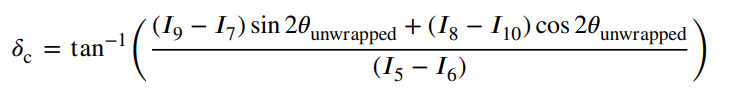


In [12]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [13]:
isochromatic_param_rad = np.nan_to_num(generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_param
))

C:\Users\zebsu\AppData\Local\Temp\ipykernel_20556\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\zebsu\AppData\Local\Temp\ipykernel_20556\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


Translate `isochromatic_param` values from `(-pi/2, pi/2)` to `(0, 255)`

In [14]:
isochromatic_param = (isochromatic_param_rad + np.pi/2)*255/(np.pi)

## Isochromatic Image Processing

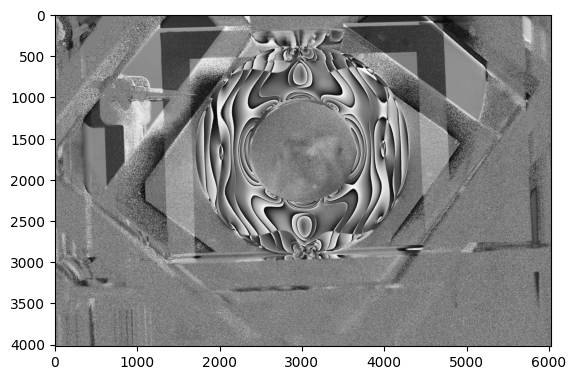

In [15]:
plt.imshow(isochromatic_param, cmap='gray')
plt.imsave('img/ring/results/ring_isochr_wr.jpg', isochromatic_param, cmap='gray')

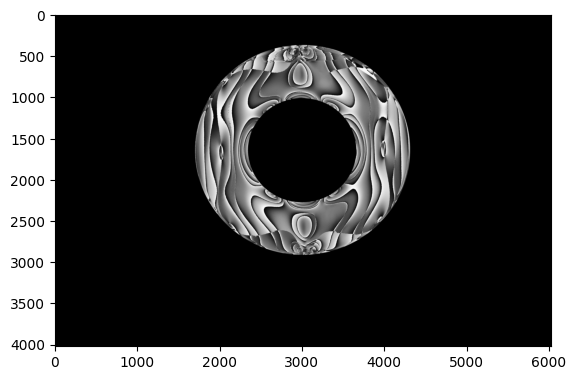

In [16]:
isochromatic_masked = cv.multiply(isochromatic_param, mask / 255)
isochromatic_masked = cv.medianBlur(isochromatic_masked.astype(np.uint8), 5)

plt.imshow(isochromatic_masked, cmap='gray')
plt.imsave('img/ring/results/ring_isochr_wr_masked.jpg',  isochromatic_masked, cmap='gray')

Generate dummy

In [17]:
# Set stack as isotropic points
stack = [(1650, 2030), (1700, 3970), (2200, 2650), (2150,3400), (2570, 2150), (2460, 3950), (1130, 2600), (1150, 3400), (800, 2080), (700, 3850)]
#create dummy array to be populated by unwrapped pixels
dummy = mask_to_dummy(mask)

# Unwrap
img_unwrapped = phase_unwrap(isochromatic_masked, stack, dummy)

0 10
500000 4912
1000000 6983
1500000 8396
2000000 9302
2500000 6654
3000000 5282
3500000 2136


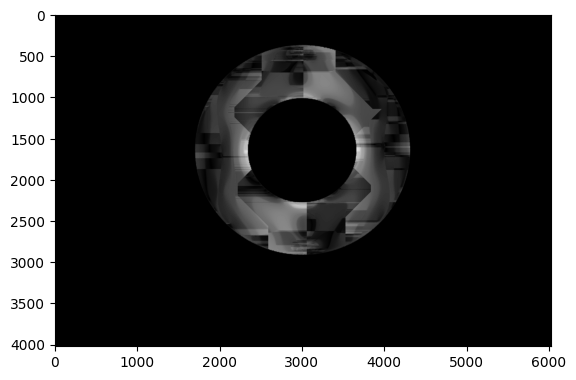

In [18]:
plt.imshow(img_unwrapped, cmap='gray')
plt.imsave('img/ring/results/ring_isochr_unwr_mask.jpg', np.nan_to_num(img_unwrapped), cmap='gray')

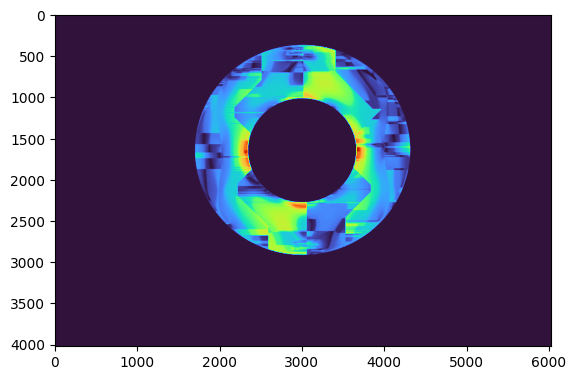

In [19]:
img = cv.medianBlur(cv.imread('img/ring/results/ring_isochr_unwr_mask.jpg', cv.IMREAD_GRAYSCALE), 5) 
plt.imshow(img, cmap='turbo')